In [ ]:
import jax.random as random
from datasets import LinearGaussianDataset, SphereDataset,SigmoidDataset  
import numpy as np
import torch.nn.functional as F
import jax
import jax.numpy as jnp
import random



In [ ]:

def generate_linear_gaussian(seed: int,
                             intrinsic_dim: int,
                             ambient_dim: int,
                             noise_var: float = 0.0,
                             n_samples: int = 20000):
    """
    对应 run.py 中：
      --dataset linear_gaussian
      -dd <intrinsic_dim>      -> dimension
      --padding_dim <pad_dim>   -> padding_dimension
      --var_added <noise_var>   -> var_added

    ambient_dim = intrinsic_dim + padding_dim
    """
    padding_dim = ambient_dim - intrinsic_dim
    ds = LinearGaussianDataset(seed=seed,
                                dimension=intrinsic_dim,
                                intrinsic_dimension=intrinsic_dim,
                                padding_dimension=padding_dim,
                                var_added=noise_var)
    # get_batch 返回 shape = (n_samples, intrinsic_dim + padding_dim)
    X = ds.get_batch(n_samples)
    return np.array(X)

if __name__ == "__main__":
    configs = [
        # intrinsic=3, ambient=12
        {"seed": 2,  "intrinsic_dim": 3,  "ambient_dim": 12},
        # intrinsic=3, ambient=20
        {"seed": 2,  "intrinsic_dim": 3,  "ambient_dim": 20},
        # intrinsic=6, ambient=12
        {"seed": 2,  "intrinsic_dim": 6,  "ambient_dim": 12},
        # intrinsic=6, ambient=20
        {"seed": 2,  "intrinsic_dim": 6,  "ambient_dim": 20},
        # intrinsic=9, ambient=12
        {"seed": 2,  "intrinsic_dim": 9,  "ambient_dim": 12},
        # intrinsic=9, ambient=20
        {"seed": 2,  "intrinsic_dim": 9,  "ambient_dim": 20},
        # intrinsic=12, ambient=20
        {"seed": 2,  "intrinsic_dim": 12, "ambient_dim": 20},
    ]

    all_datasets = {}

    for cfg in configs:
        key = f"intrinsic{cfg['intrinsic_dim']}_ambient{cfg['ambient_dim']}"
        X = generate_linear_gaussian(seed=cfg["seed"],
                                 intrinsic_dim=cfg["intrinsic_dim"],
                                 ambient_dim=cfg["ambient_dim"],
                                 noise_var=0.0,
                                 n_samples=20000)
        all_datasets[key] = X
        print(f"Generated {key}: X.shape = {X.shape}")



Generated intrinsic3_ambient12: X.shape = (20000, 12)
Generated intrinsic3_ambient20: X.shape = (20000, 20)
Generated intrinsic6_ambient12: X.shape = (20000, 12)
Generated intrinsic6_ambient20: X.shape = (20000, 20)
Generated intrinsic9_ambient12: X.shape = (20000, 12)
Generated intrinsic9_ambient20: X.shape = (20000, 20)
Generated intrinsic12_ambient20: X.shape = (20000, 20)


## Diffusion Model (DDPM) - linear case

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import os


In [97]:

class DenoiseMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x, t):
        t = t.float().unsqueeze(-1) / 1000
        x_input = torch.cat([x, t], dim=-1)
        return self.net(x_input)



In [104]:
class Diffusion:
    def __init__(self, model, timesteps=1000, loss_type='huber'):
        self.model = model
        self.timesteps = timesteps
        self.loss_type = loss_type

        # Cosine beta schedule
        steps = np.linspace(0, np.pi / 2, timesteps + 1)
        alphas_cumprod = np.cos(steps) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

        self.alphas_cumprod = torch.tensor(alphas_cumprod[:-1], dtype=torch.float32)
        self.betas = 1 - self.alphas_cumprod[1:] / self.alphas_cumprod[:-1]
        self.betas = torch.cat([self.betas, self.betas[-1].unsqueeze(0)], dim=0)
        self.alphas = 1.0 - self.betas

        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_cumprod = self.alphas_cumprod[t].unsqueeze(1).sqrt().to(x0.device)
        sqrt_one_minus = (1 - self.alphas_cumprod[t]).unsqueeze(1).sqrt().to(x0.device)
        return sqrt_alpha_cumprod * x0 + sqrt_one_minus * noise

    def p_losses(self, x0, t):
        noise = torch.randn_like(x0)
        x_noisy = self.q_sample(x0, t, noise)
        noise_pred = self.model(x_noisy, t)
        if self.loss_type == 'mse':
            return F.mse_loss(noise_pred, noise)
        elif self.loss_type == 'huber':
            return F.smooth_l1_loss(noise_pred, noise)

    def p_sample(self, x, t):
        noise_pred = self.model(x, t)
        beta_t = self.betas[t].unsqueeze(1).to(x.device)
        alpha_t = self.alphas[t].unsqueeze(1).to(x.device)
        alpha_cumprod_t = self.alphas_cumprod[t].unsqueeze(1).to(x.device)

        mean = (1 / alpha_t.sqrt()) * (x - beta_t / (1 - alpha_cumprod_t).sqrt() * noise_pred)

        if t[0] == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            return mean + beta_t.sqrt() * noise

    def sample(self, num_samples, dim, device):
        x = torch.randn(num_samples, dim).to(device)
        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
            x = self.p_sample(x, t_batch)
        return x


In [107]:
def train_diffusion_and_evaluate(all_datasets, device="cuda" if torch.cuda.is_available() else "cpu"):
    import numpy as np
    import os
    from sklearn.decomposition import PCA
    from torch.utils.data import DataLoader, TensorDataset
    import torch
    from tqdm import tqdm

    os.makedirs("generated_samples", exist_ok=True)
    final_results = {}

    def get_intrinsic_dim_from_key(key):
        try:
            return int(key.split('_')[0].replace('intrinsic', ''))
        except:
            raise ValueError(f"Cannot parse intrinsic dimension from key: {key}")

    def mean_normalized_eigenvalue_error(X_real, X_fake, intrinsic_dim):
        pca_real = PCA(n_components=intrinsic_dim).fit(X_real)
        pca_fake = PCA(n_components=intrinsic_dim).fit(X_fake)
        λ_real = pca_real.explained_variance_
        λ_fake = pca_fake.explained_variance_
        return np.linalg.norm(λ_fake - λ_real) / np.linalg.norm(λ_real)

    def explained_variance_coverage_error(X_real, X_fake, intrinsic_dim):
        pca_real = PCA().fit(X_real)
        pca_fake = PCA().fit(X_fake)
        var_real = pca_real.explained_variance_ratio_
        var_fake = pca_fake.explained_variance_ratio_
        return abs(np.sum(var_fake[:intrinsic_dim]) - np.sum(var_real[:intrinsic_dim]))

    for key, X in all_datasets.items():
        print(f"\n🚀 Training on config: {key}, shape = {X.shape}")
        intrinsic_dim = get_intrinsic_dim_from_key(key)

        evce_runs = []
        mnee_runs = []

        for run in range(3):  # 三次实验
            print(f"🔁 Run {run+1}/3")

            X_tensor = torch.tensor(X, dtype=torch.float32)
            dataset = TensorDataset(X_tensor)
            dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

            model = DenoiseMLP(input_dim=X.shape[1]).to(device)
            diffusion = Diffusion(model, timesteps=1000, loss_type='huber')
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

            # === Train ===
            for epoch in range(500):
                losses = []
                for batch in dataloader:
                    x0 = batch[0].to(device)
                    t = torch.randint(0, diffusion.timesteps, (x0.shape[0],), device=device)
                    loss = diffusion.p_losses(x0, t)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    losses.append(loss.item())

                if (epoch + 1) % 10 == 0 or epoch == 0:
                    avg_loss = sum(losses) / len(losses)
                    print(f"[{key}] Epoch {epoch+1} - Avg Loss: {avg_loss:.6f}")


            # === Sample and Evaluate ===
            model.eval()
            with torch.no_grad():
                samples = diffusion.sample(num_samples=20000, dim=X.shape[1], device=device)
                samples = samples.cpu().numpy()
                np.save(f"generated_samples/{key}_run{run+1}_samples.npy", samples)

            evce = explained_variance_coverage_error(X, samples, intrinsic_dim)
            mnee = mean_normalized_eigenvalue_error(X, samples, intrinsic_dim)
            evce_runs.append(evce)
            mnee_runs.append(mnee)

        evce_mean = np.mean(evce_runs)
        mnee_mean = np.mean(mnee_runs)
        final_results[key] = {"EVCE": evce_mean, "MNEE": mnee_mean}

        print(f"[{key}] 🔍 EVCE (dim alignment): {evce_mean:.6f}")
        print(f"[{key}] 📉 MNEE (density error):  {mnee_mean:.6f}")

    print("\n📊 Final Aggregated Results:")
    for key, vals in final_results.items():
        print(f"{key} → EVCE: {vals['EVCE']:.4f}, MNEE: {vals['MNEE']:.4f}")


In [108]:
train_diffusion_and_evaluate(all_datasets)



🚀 Training on config: intrinsic3_ambient12, shape = (20000, 12)
🔁 Run 1/3
[intrinsic3_ambient12] Epoch 1 - Avg Loss: 0.332755
[intrinsic3_ambient12] Epoch 10 - Avg Loss: 0.116237
[intrinsic3_ambient12] Epoch 20 - Avg Loss: 0.093720
[intrinsic3_ambient12] Epoch 30 - Avg Loss: 0.085155
[intrinsic3_ambient12] Epoch 40 - Avg Loss: 0.079815
[intrinsic3_ambient12] Epoch 50 - Avg Loss: 0.076738
[intrinsic3_ambient12] Epoch 60 - Avg Loss: 0.075812
[intrinsic3_ambient12] Epoch 70 - Avg Loss: 0.073393
[intrinsic3_ambient12] Epoch 80 - Avg Loss: 0.071487
[intrinsic3_ambient12] Epoch 90 - Avg Loss: 0.071045
[intrinsic3_ambient12] Epoch 100 - Avg Loss: 0.070905
[intrinsic3_ambient12] Epoch 110 - Avg Loss: 0.069909
[intrinsic3_ambient12] Epoch 120 - Avg Loss: 0.070499
[intrinsic3_ambient12] Epoch 130 - Avg Loss: 0.068606
[intrinsic3_ambient12] Epoch 140 - Avg Loss: 0.068266
[intrinsic3_ambient12] Epoch 150 - Avg Loss: 0.069321
[intrinsic3_ambient12] Epoch 160 - Avg Loss: 0.068967
[intrinsic3_ambien

Final Aggregated Results:

intrinsic3_ambient12 → EVCE: 0.0000, MNEE: 0.0831  

intrinsic3_ambient20 → EVCE: 0.0001, MNEE: 0.2136  

intrinsic6_ambient12 → EVCE: 0.0000, MNEE: 0.0751  

intrinsic6_ambient20 → EVCE: 0.0000, MNEE: 0.3289

intrinsic9_ambient12 → EVCE: 0.0000, MNEE: 0.0390

intrinsic9_ambient20 → EVCE: 0.0000, MNEE: 0.1958

intrinsic12_ambient20 → EVCE: 0.0000, MNEE: 1.0936

### Metrics

In [9]:
from sklearn.decomposition import PCA
import numpy as np

def pca_eigenvalue_error(real, fake, n_components=None):
    pca_real = PCA(n_components=n_components)
    pca_fake = PCA(n_components=n_components)

    pca_real.fit(real)
    pca_fake.fit(fake)

    ev_real = pca_real.explained_variance_
    ev_fake = pca_fake.explained_variance_

    ev_real /= ev_real.sum()
    ev_fake /= ev_fake.sum()

    return np.mean(np.abs(ev_real - ev_fake))


## Sigmoid case

In [80]:


def generate_sigmoid_datasets(seed=42, num_samples=20000):
    rng = jax.random.PRNGKey(seed)
    all_datasets_sigmoid = {}

    configs = [
        (3, 7),
        (3, 17),
        (5, 11),
        (5, 22),
        (7, 15),
        (7, 28),
    ]

    for intrinsic, ambient in configs:
        padding_dim = ambient - (intrinsic + 1)  # +1 是 sigmoid 扩展出的维度
        key = f"intrinsic{intrinsic}_ambient{ambient}"
        dataset = SigmoidDataset(seed=seed, dimension=intrinsic, padding_dimension=padding_dim)
        data = np.array(dataset.get_batch(num_samples))  # shape = [num_samples, ambient]
        all_datasets_sigmoid[key] = data

    return all_datasets_sigmoid


In [121]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def train_diffusion_on_sigmoid_with_metrics(all_datasets, device="cuda" if torch.cuda.is_available() else "cpu"):
    os.makedirs("generated_sigmoid_samples", exist_ok=True)
    final_results = {}

    num_runs = 3
    total_epochs = 50
    record_interval = 10

    for key, X in all_datasets.items():
        print(f"\n🔁 Running 3x for config: {key}, shape = {X.shape}")

        # For aggregating across runs
        losses_all_runs = []
        manifold_errors_all_runs = []
        padding_errors_all_runs = []
        evce_all_runs = []

        for run in range(num_runs):
            print(f"Run {run+1}/{num_runs}")
            X_tensor = torch.tensor(X, dtype=torch.float32)
            dataset = TensorDataset(X_tensor)
            dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

            model = DenoiseMLP(input_dim=X.shape[1]).to(device)
            diffusion = Diffusion(model, timesteps=1000)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            losses = []
            manifold_errors = []
            padding_errors = []
            evce_errors = []

            for epoch in range(1, total_epochs + 1):
                batch_losses = []
                model.train()
                for batch in dataloader:
                    x0 = batch[0].to(device)
                    t = torch.randint(0, 1000, (x0.shape[0],), device=device)
                    loss = diffusion.p_losses(x0, t)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    batch_losses.append(loss.item())

                if epoch % record_interval == 0:
                    avg_loss = np.mean(batch_losses)
                    losses.append(avg_loss)
                    print(f"[{key}] Epoch {epoch} - Avg Loss: {avg_loss:.6f}")

                    # Sample for evaluation
                    model.eval()
                    with torch.no_grad():
                        samples = diffusion.sample(num_samples=10000, dim=X.shape[1], device=device).cpu().numpy()

                    intrinsic = int(key.split("_")[0].replace("intrinsic", ""))
                    padding = int(key.split("_")[1].replace("ambient", "")) - (intrinsic + 1)
                    dataset_obj = SigmoidDataset(seed=0, dimension=intrinsic, padding_dimension=padding)

                    scores = dataset_obj.score_batch(samples)
                    manifold_error = float(scores["Squared Norm of Manifold Dimension"])
                    padding_error = float(scores["Squared Norm of Padding Dimensions"])
                    evce = pca_eigenvalue_error(X, samples, n_components=min(10, X.shape[1]))

                    manifold_errors.append(manifold_error)
                    padding_errors.append(padding_error)
                    evce_errors.append(evce)

            # Save one run's results
            losses_all_runs.append(losses)
            manifold_errors_all_runs.append(manifold_errors)
            padding_errors_all_runs.append(padding_errors)
            evce_all_runs.append(evce_errors)

        # Take average across runs
        mean_losses = np.mean(losses_all_runs, axis=0)
        mean_manifold = np.mean(manifold_errors_all_runs, axis=0)
        mean_padding = np.mean(padding_errors_all_runs, axis=0)
        mean_evce = np.mean(evce_all_runs, axis=0)

        final_results[key] = {
            "loss": mean_losses,
            "manifold": mean_manifold,
            "padding": mean_padding,
            "evce": mean_evce
        }

    return final_results


In [116]:
import matplotlib.pyplot as plt
import numpy as np

def plot_diffusion_sigmoid_results(results, record_interval=10):
    configs = list(results.keys())
    epochs = np.arange(1, len(next(iter(results.values()))["loss"]) + 1) * record_interval

    # Set up figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Manifold Error
    for key in configs:
        axs[0].plot(epochs, results[key]["manifold"], label=key)
    axs[0].set_title("Manifold Error")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Error")
    axs[0].legend()

    # Plot 2: EVCE (used as Decoder Variance)
    for key in configs:
        axs[1].plot(epochs, results[key]["evce"], label=key)
    axs[1].set_title("EVCE (Decoder Variance Proxy)")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("EVCE")
    axs[1].legend()

    # Plot 3: Diffusion Loss
    for key in configs:
        axs[2].plot(epochs, results[key]["loss"], label=key)
    axs[2].set_title("Diffusion Loss")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Loss")
    axs[2].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
'''
def train_diffusion_on_sigmoid(all_datasets, device="cuda" if torch.cuda.is_available() else "cpu"):
    os.makedirs("generated_sigmoid_samples", exist_ok=True)
    results = {}

    for key, X in all_datasets.items():
        print(f"\n🚀 Training on config: {key}, shape = {X.shape}")
        X_tensor = torch.tensor(X, dtype=torch.float32)
        dataset = TensorDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        model = DenoiseMLP(input_dim=X.shape[1]).to(device)
        diffusion = Diffusion(model, timesteps=1000)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        # === Training ===
        for epoch in range(300):  # 可调大
            for batch in dataloader:
                x0 = batch[0].to(device)
                t = torch.randint(0, 1000, (x0.shape[0],), device=device)
                loss = diffusion.p_losses(x0, t)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f"[{key}] Epoch {epoch+1} - Loss: {loss.item():.4f}")

        # === Sampling ===
        model.eval()
        with torch.no_grad():
            samples = diffusion.sample(num_samples=20000, dim=X.shape[1], device=device)
            samples = samples.cpu().numpy()
            np.save(f"generated_sigmoid_samples/{key}_samples.npy", samples)

        # === Evaluate ===
        intrinsic = int(key.split("_")[0].replace("intrinsic", ""))
        padding = int(key.split("_")[1].replace("ambient", "")) - (intrinsic + 1)
        dataset_obj = SigmoidDataset(seed=0, dimension=intrinsic, padding_dimension=padding)

        # 1️⃣ Manifold Error
        scores = dataset_obj.score_batch(jnp.array(samples))
        manifold_error = float(scores["Squared Norm of Manifold Dimension"])
        padding_error = float(scores["Squared Norm of Padding Dimensions"])

        # 2️⃣ PCA eigenvalue error
        pca_error = pca_eigenvalue_error(X, samples, n_components=min(10, X.shape[1]))

        results[key] = {
            "manifold_error": manifold_error,
            "padding_error": padding_error,
            "pca_error": pca_error
        }

        print(f"[{key}] ✅ Manifold Error: {manifold_error:.6f} | Padding Error: {padding_error:.6f} | PCA Error: {pca_error:.6f}")

    print("\n📊 Final Results:")
    for key, vals in results.items():
        print(f"{key} → Manifold: {vals['manifold_error']:.4f}, Padding: {vals['padding_error']:.4f}, PCA: {vals['pca_error']:.4f}")
'''



🔁 Running 3x for config: intrinsic3_ambient7, shape = (20000, 7)
Run 1/3
[intrinsic3_ambient7] Epoch 10 - Avg Loss: 0.103064
[intrinsic3_ambient7] Epoch 20 - Avg Loss: 0.101834
[intrinsic3_ambient7] Epoch 30 - Avg Loss: 0.100231
[intrinsic3_ambient7] Epoch 40 - Avg Loss: 0.100083
[intrinsic3_ambient7] Epoch 50 - Avg Loss: 0.099513
Run 2/3
[intrinsic3_ambient7] Epoch 10 - Avg Loss: 0.103155
[intrinsic3_ambient7] Epoch 20 - Avg Loss: 0.100856
[intrinsic3_ambient7] Epoch 30 - Avg Loss: 0.101452
[intrinsic3_ambient7] Epoch 40 - Avg Loss: 0.100068
[intrinsic3_ambient7] Epoch 50 - Avg Loss: 0.099607
Run 3/3
[intrinsic3_ambient7] Epoch 10 - Avg Loss: 0.102780
[intrinsic3_ambient7] Epoch 20 - Avg Loss: 0.101945
[intrinsic3_ambient7] Epoch 30 - Avg Loss: 0.101111
[intrinsic3_ambient7] Epoch 40 - Avg Loss: 0.099571
[intrinsic3_ambient7] Epoch 50 - Avg Loss: 0.100771

🔁 Running 3x for config: intrinsic3_ambient17, shape = (20000, 17)
Run 1/3
[intrinsic3_ambient17] Epoch 10 - Avg Loss: 0.053695
[

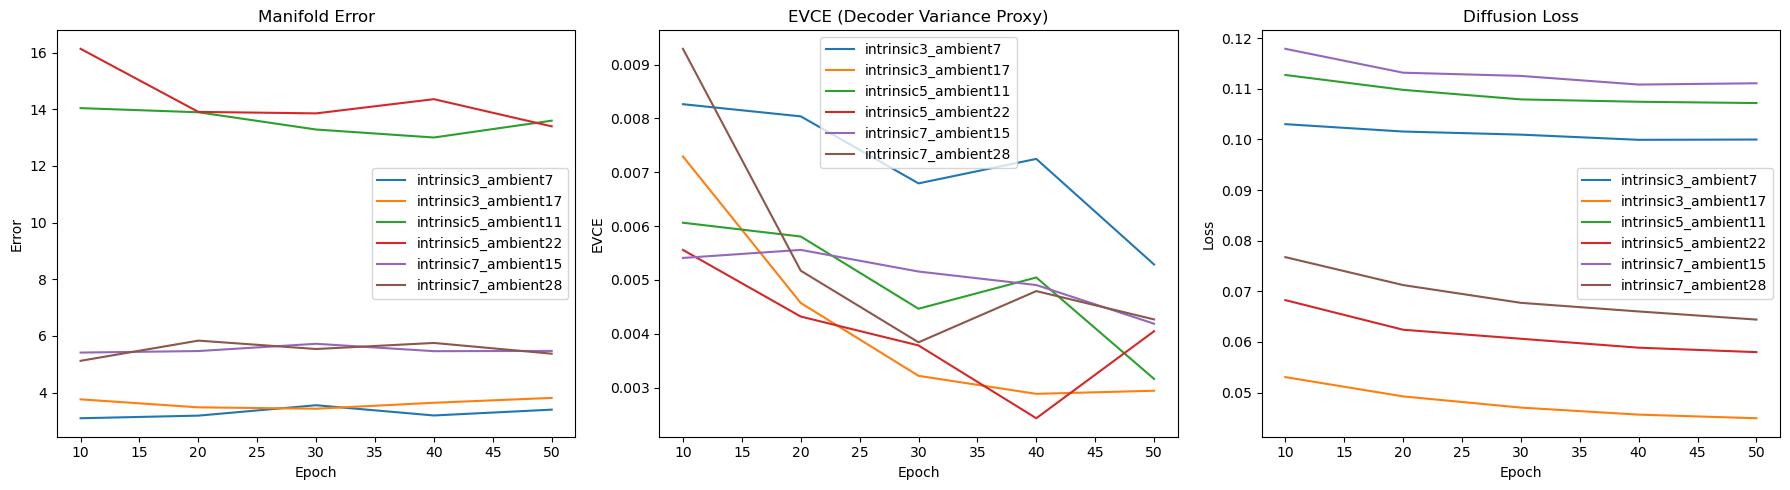

In [122]:
# 1️⃣ 生成 Sigmoid 数据集
all_sigmoid_datasets = generate_sigmoid_datasets()

# 2️⃣ 开始训练并记录指标（manifold error, EVCE, diffusion loss）
results = train_diffusion_on_sigmoid_with_metrics(all_sigmoid_datasets)

# 3️⃣ 可视化结果
plot_diffusion_sigmoid_results(results)
